In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import randint as sp_randint
from time import time
from sklearn.metrics import roc_curve, auc
from scipy import interp
from pylab import rcParams
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score

In [2]:
rcParams['figure.figsize'] = 12, 8

In [3]:
df = pd.read_csv('/home/alexshein/processed_pals/S10-20_L0-8_M5/All_shuffled.csv', sep=';')
df = df[[i for i in list(df.columns) if i not in ('Unnamed: 0')]]
df = df.fillna(value=0.0)

In [4]:
df.describe()

,AA,AAA,AAC,AAG,AAT,AC,ACA,ACC,ACG,ACT,...,TGA,TGC,TGG,TGT,TT,TTA,TTC,TTG,TTT,is_target
count,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.00000,...,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000,24928.000000
mean,0.442715,0.101733,0.051869,0.066030,0.079429,0.366496,0.067555,0.039795,0.013599,0.11453,...,0.054878,0.023909,0.043245,0.058208,0.620226,0.067033,0.276877,0.045491,0.086810,0.498596
std,0.733689,0.322341,0.225535,0.254404,0.289056,0.586406,0.258233,0.198333,0.116513,0.32445,...,0.232109,0.154076,0.208283,0.239560,0.710338,0.265642,0.450680,0.214268,0.301382,0.500008
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,5.000000,3.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.00000,...,2.000000,2.000000,2.000000,2.000000,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000


In [5]:
df[df['is_target']==1]['GC precentage'].describe()

count    12429.000000
mean        42.697300
std          9.640165
min          0.000000
25%         36.000000
50%         45.454545
75%         50.000000
max         68.000000
Name: GC precentage, dtype: float64

In [6]:
df[df['is_target']==0]['GC precentage'].describe()

count    12499.000000
mean        23.824131
std         13.458393
min          0.000000
25%         13.636364
50%         22.727273
75%         32.000000
max         73.913043
Name: GC precentage, dtype: float64

In [7]:
dfX = df[[i for i in list(df.columns) if i not in ('is_target')]]
dfY = df['is_target']

In [8]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=5)

In [9]:
def draw_roc_auc(dfX, dfY, rf):
    folded_data = model_selection.KFold(n_splits=5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0

    for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
        probas_ = rf.fit(dfX.iloc[train], dfY.iloc[train]).predict_proba(dfX.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc)
        )

    plt.plot(
        [0, 1],
        [0, 1],
        linestyle='--',
        lw=2,
        color='r',
        label='Luck',
        alpha=.8
    )
    fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color='grey',
        alpha=.2,
        label=r'$\pm$ 1 std. dev.'
    )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for transposon recognition')
    plt.legend(loc="lower right")
    plt.show()
    list(sorted(zip(dfX.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True))[:20]

In [10]:
def draw_precision_recall(dfX, dfY, rf):
    folded_data = model_selection.KFold(n_splits=5)
    precisions = []
    recalls = []
    accuracies = []
    for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
        rf.fit(dfX.iloc[train], dfY.iloc[train])
        probas_ = rf.predict_proba(dfX.iloc[test])
        predictions_ = rf.predict(dfX.iloc[test])
        precision, recall, _ = precision_recall_curve(dfY.iloc[test], probas_[:, 1])
        precisions.append(average_precision_score(dfY.iloc[test], probas_[:, 1]))
        recalls.append(recall_score(dfY.iloc[test], predictions_))
        accuracies.append(accuracy_score(dfY.iloc[test], predictions_))
        plt.step(
            recall,
            precision,
            alpha=0.5,
            where='post',
            label='Precision-recall fold {}'.format(k)
        )
    average_precision = np.mean(precisions)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.legend(loc="lower right")
    plt.show()
    print('Precision: ', average_precision, ' Recall: ', np.mean(recalls), ' Accuracy: ', np.mean(accuracies))

In [11]:
# Results WITH Di-Trinucleotides count features

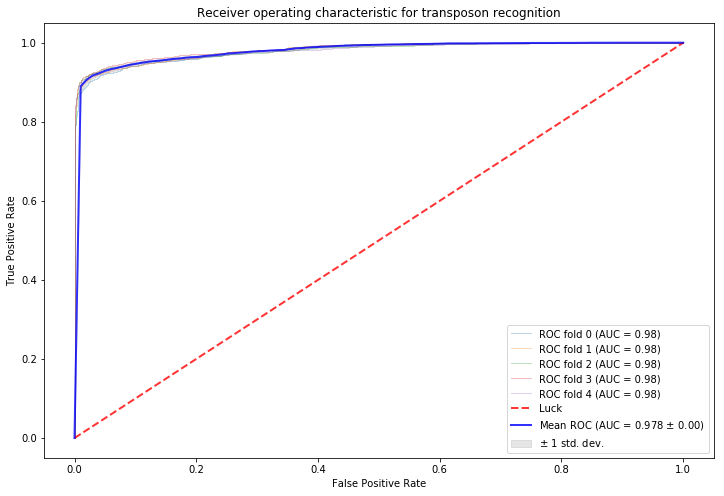

[('AG', 0.06749611491941845),
 ('GAG', 0.06172280505537624),
 ('CTC', 0.06023081488761099),
 ('GC precentage', 0.05163740367039037),
 ('LS0Hydrophilicity (RNA)', 0.04542241321765427),
 ('TC', 0.04252856158874578),
 ('RS0Rise (RNA)', 0.03207248199882027),
 ('LS0Twist (RNA)', 0.030286098128093214),
 ('RS0Free energy (RNA)', 0.02891194822211568),
 ('RS0Hydrophilicity (RNA)', 0.02439860666183507),
 ('LS6Hydrophilicity (RNA)', 0.02399852020160339),
 ('RS0Tilt (RNA)', 0.022497727698713384),
 ('RS6Hydrophilicity (RNA)', 0.018977570091924374),
 ('RS0Enthalpy (RNA)', 0.01772786497329103),
 ('RS0Entropy (RNA)', 0.017625670535931073),
 ('RS0Slide (RNA)', 0.015896952790557296),
 ('RS7Tilt (RNA)', 0.015343780780820715),
 ('CT', 0.013887030202845159),
 ('AGA', 0.013262386754382833),
 ('LS0Rise (RNA)', 0.013097582801820112)]

In [12]:
draw_roc_auc(dfX, dfY, rf)
list(sorted(zip(dfX.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True))[:20]

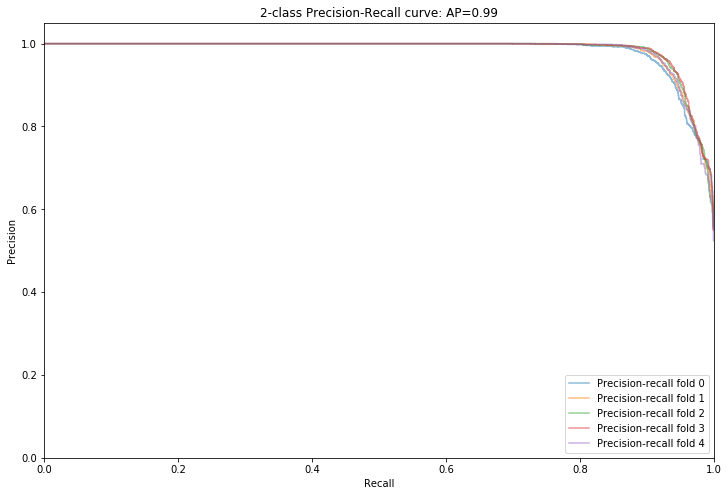

Precision:  0.9853662385327763  Recall:  0.8919121823458529  Accuracy:  0.9402279119749941


In [13]:
draw_precision_recall(dfX, dfY, rf)

In [14]:
df2 = df[
    [col for col in list(df.columns) if col.startswith('LP') or
     col.startswith('LB') or
     col.startswith('RB') or
     col.startswith('LS') or
     col.startswith('RS') or
     col.startswith('GC p') or
     col == 'is_target'
    ]
]

In [15]:
df2.head()

,GC precentage,LB0A,LB0C,LB0G,LB0T,LB1A,LB1C,LB1G,LB1T,LB2A,...,RS8Entropy (RNA),RS8Free energy (RNA),RS8Hydrophilicity (RNA),RS8Rise (RNA),RS8Roll (RNA),RS8Shift (RNA),RS8Slide (RNA),RS8Tilt (RNA),RS8Twist (RNA),is_target
0,50.000000,1,0,0,0,0,0,1,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1
1,42.857143,1,0,0,0,0,0,1,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1
2,31.818182,1,0,0,0,0,0,1,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1
3,27.272727,0,0,0,1,0,1,0,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1
4,22.727273,0,1,0,0,1,0,0,0,1,...,-27.1000,-2.080000,0.520,3.3000,8.5,-0.040000,-1.500000,0.5000,30.0000,0


In [16]:
df2X = df2[[i for i in list(df2.columns) if i not in ('is_target')]]
df2Y = df2['is_target']

In [17]:
rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=5)


In [18]:
# Results WITHOUT Di-Trinucleotides count features

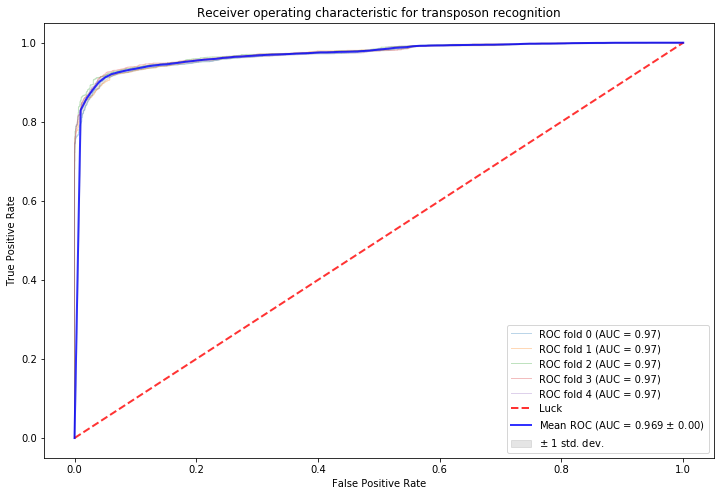

[('GC precentage', 0.08295376367906199),
 ('RS0Rise (RNA)', 0.06701021441636076),
 ('RS6Hydrophilicity (RNA)', 0.05431421168907656),
 ('RS0Hydrophilicity (RNA)', 0.0532243553416665),
 ('RS0Tilt (RNA)', 0.04801383614107813),
 ('LS0Twist (RNA)', 0.0462088456801638),
 ('LS0Hydrophilicity (RNA)', 0.043540897050453664),
 ('LS0Tilt (RNA)', 0.03281172420645593),
 ('RS0Slide (RNA)', 0.027938928781956182),
 ('LS7Twist (RNA)', 0.02719655036759359),
 ('RS0Free energy (RNA)', 0.023943102617096947),
 ('LS0Rise (RNA)', 0.023726094847945092),
 ('LS6Hydrophilicity (RNA)', 0.022906812404798704),
 ('LS6Rise (RNA)', 0.020653116787579612),
 ('RS0Entropy (RNA)', 0.017674090425057933),
 ('RS6Twist (RNA)', 0.016534675307808527),
 ('LS7Hydrophilicity (RNA)', 0.01601780105061484),
 ('LS6Enthalpy (RNA)', 0.011145467306509196),
 ('LB2G', 0.010852027930347778),
 ('RS3Hydrophilicity (RNA)', 0.01052989112443951)]

In [19]:
draw_roc_auc(df2X, df2Y, rf2)
list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x:x[1], reverse=True))[:20]

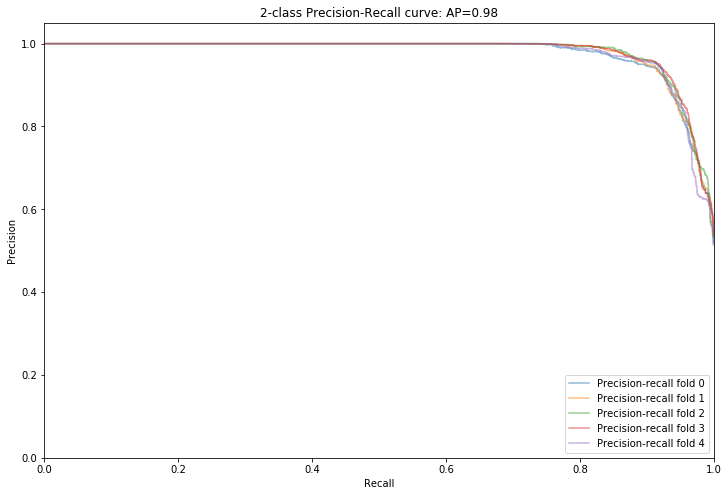

Precision:  0.9792422893062664  Recall:  0.8407071937336337  Accuracy:  0.9134708014939322


In [20]:
draw_precision_recall(df2X, df2Y, rf2)